In [18]:
import torch
from torch_geometric.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR

from gnn import GNN

import os
from tqdm import tqdm
import argparse
import time
import numpy as np
import random

torch.cuda.is_available()

True

In [11]:
device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [5]:
# get args from main_gnn CLI
class Argument(object):
    name = "args"
    
args = Argument()
args.batch_size = 256
args.num_workers = 0
args.num_layers = 5
args.emb_dim = 600
args.drop_ratio = 0
args.graph_pooling = "sum"
args.checkpoint_dir = "checkpoint"
args.device = 0

In [9]:
shared_params = {
    'num_layers': args.num_layers,
    'emb_dim': args.emb_dim,
    'drop_ratio': args.drop_ratio,
    'graph_pooling': args.graph_pooling
}


In [6]:
"""
LOAD Checkpoint data
"""
checkpoint = torch.load(os.path.join(args.checkpoint_dir, 'checkpoint.pt'))
checkpoint

{'epoch': 10,
 'model_state_dict': OrderedDict([('gnn_node.atom_encoder.atom_embedding_list.0.weight',
               tensor([[-0.0070,  0.4733, -0.5016,  ..., -0.1851,  0.1217,  0.1224],
                       [-0.1166,  0.3726, -0.0687,  ..., -0.4926, -0.1549, -0.2870],
                       [ 0.0401, -0.0115, -0.0072,  ..., -0.0628,  0.0563,  0.0835],
                       ...,
                       [-0.0571,  0.0159,  0.0011,  ...,  0.0244, -0.0200,  0.0333],
                       [-0.0164, -0.0172,  0.0837,  ...,  0.0640,  0.0729, -0.0326],
                       [-0.0652,  0.0050,  0.0020,  ...,  0.0402,  0.0093, -0.0330]],
                      device='cuda:0')),
              ('gnn_node.atom_encoder.atom_embedding_list.1.weight',
               tensor([[-0.0057,  0.1436, -0.2069,  ..., -0.0602, -0.0150,  0.1488],
                       [-0.0316, -0.0139,  0.0699,  ...,  0.0701, -0.0874, -0.2683],
                       [-0.0034, -0.0382,  0.0182,  ...,  0.0912, -0.0584, -0.

In [7]:
from gnn import GNN

In [13]:
model = GNN(gnn_type = 'gcn', virtual_node = False, **shared_params).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.state_dict()

OrderedDict([('gnn_node.atom_encoder.atom_embedding_list.0.weight',
              tensor([[-0.0070,  0.4733, -0.5016,  ..., -0.1851,  0.1217,  0.1224],
                      [-0.1166,  0.3726, -0.0687,  ..., -0.4926, -0.1549, -0.2870],
                      [ 0.0401, -0.0115, -0.0072,  ..., -0.0628,  0.0563,  0.0835],
                      ...,
                      [-0.0571,  0.0159,  0.0011,  ...,  0.0244, -0.0200,  0.0333],
                      [-0.0164, -0.0172,  0.0837,  ...,  0.0640,  0.0729, -0.0326],
                      [-0.0652,  0.0050,  0.0020,  ...,  0.0402,  0.0093, -0.0330]],
                     device='cuda:0')),
             ('gnn_node.atom_encoder.atom_embedding_list.1.weight',
              tensor([[-0.0057,  0.1436, -0.2069,  ..., -0.0602, -0.0150,  0.1488],
                      [-0.0316, -0.0139,  0.0699,  ...,  0.0701, -0.0874, -0.2683],
                      [-0.0034, -0.0382,  0.0182,  ...,  0.0912, -0.0584, -0.3024],
                      [-0.0125,  0.0622,

In [14]:
### importing OGB-LSC
from ogb.lsc import PygPCQM4MDataset, PCQM4MEvaluator

dataset = PygPCQM4MDataset(root = 'dataset/')

In [15]:
split_idx = dataset.get_idx_split()
split_idx["train"], split_idx["test"], split_idx["valid"]

(tensor([      0,       1,       2,  ..., 3045357, 3045358, 3045359]),
 tensor([3426030, 3426031, 3426032,  ..., 3803450, 3803451, 3803452]),
 tensor([3045360, 3045361, 3045362,  ..., 3426027, 3426028, 3426029]))

In [16]:
evaluator = PCQM4MEvaluator()

In [19]:
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)

In [21]:
def eval(model, device, loader, evaluator):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch).view(-1,)

        y_true.append(batch.y.view(pred.shape).detach().cpu())
        y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim = 0)
    y_pred = torch.cat(y_pred, dim = 0)

    input_dict = {"y_true": y_true, "y_pred": y_pred}

    return evaluator.eval(input_dict)["mae"]

In [22]:
valid_mae = eval(model, device, valid_loader, evaluator)
valid_mae

Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [01:46<00:00, 13.94it/s]


0.20546191930770874

In [47]:
model.eval()
y_true = []
y_pred = []

valid_data_list = []
for step, batch in enumerate(tqdm(valid_loader, desc="Iteration")):
    # keep track of data
    for i in range(batch.y.shape[0]):
        valid_data_list.append(batch[i])
    
    batch = batch.to(device)

    with torch.no_grad():
        pred = model(batch).view(-1,)

    y_true.extend(batch.y.view(pred.shape).detach().cpu().tolist())
    y_pred.extend(pred.detach().cpu().tolist())
    

Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [01:25<00:00, 17.48it/s]


In [48]:
import pandas as pd

In [136]:
"""
analyse data that are predicted wrong the most
"""

validDF = pd.DataFrame(zip(y_true, y_pred), columns=["y_true", "y_pred"])
validDF["data"] = valid_data_list
validDF["error"] = validDF["y_pred"] - validDF["y_true"]
validDF["absError"] = abs(validDF["error"])
validDF = validDF.sort_values("absError", ascending=False)

validDF.reset_index(inplace=True)

validDF

TypeError: zip argument #2 must support iteration

Text(0, 0.5, 'log-count')

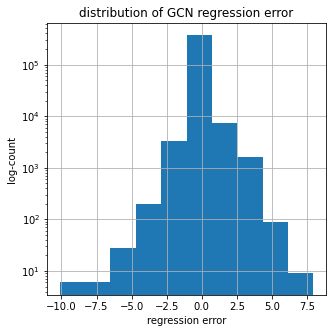

In [140]:
ax = validDF["error"].hist(log=True, figsize=(5, 5))
ax.set_title("distribution of GCN regression error")
ax.set_xlabel("regression error")
ax.set_ylabel("log-count")

In [64]:
import matplotlib.pyplot as plt
import networkx as nx

In [161]:
def plotGraph(filtDF, title):
    sizeX = 8
    sizeY = int(filtDF.shape[0] / sizeX) + 1

    print(title)
    fig, ax = plt.subplots(sizeX, sizeY,figsize=(20, 20))
#     fig.suptitle(title)

    i = 0
    j = 0
    for _, row in filtDF.iterrows():
        data = row["data"]
        y_pred = row["y_pred"]
        y_true = row["y_true"]
        edges = data.edge_index.T.tolist()
        edges = np.array(edges)

        G = nx.Graph()
        G.add_nodes_from(range(data.x.shape[0]))
        G.add_edges_from(edges)

        ax[i][j].set_title("pred={:.2f}, true={:.2f}".format(y_pred, y_true))
        nx.draw(G, node_size=40, ax=ax[i][j])

        i += 1
        if i == sizeX:
            i = 0
            j += 1

correctly predicted


,index,y_true,y_pred,data,error,absError
380669,224702,5.583776,5.583776,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",-4.768372e-07,4.768372e-07
380668,202289,5.243634,5.243633,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",-4.768372e-07,4.768372e-07
380667,279100,5.083086,5.083087,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",9.536743e-07,9.536743e-07
380666,343150,6.128004,6.128003,"[(edge_attr, [tensor([2, 0, 0]), tensor([2, 0,...",-1.430511e-06,1.430511e-06
380665,379794,5.559286,5.559288,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",1.907349e-06,1.907349e-06
380664,246868,4.786483,4.786486,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",2.861023e-06,2.861023e-06
380663,10266,4.307562,4.307559,"[(edge_attr, [tensor([1, 0, 1]), tensor([1, 0,...",-2.861023e-06,2.861023e-06
380662,242171,6.261340,6.261344,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",4.768372e-06,4.768372e-06
380661,248808,5.817794,5.817800,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",5.245209e-06,5.245209e-06
380660,115239,6.979720,6.979726,"[(edge_attr, [tensor([1, 0, 0]), tensor([1, 0,...",5.722046e-06,5.722046e-06


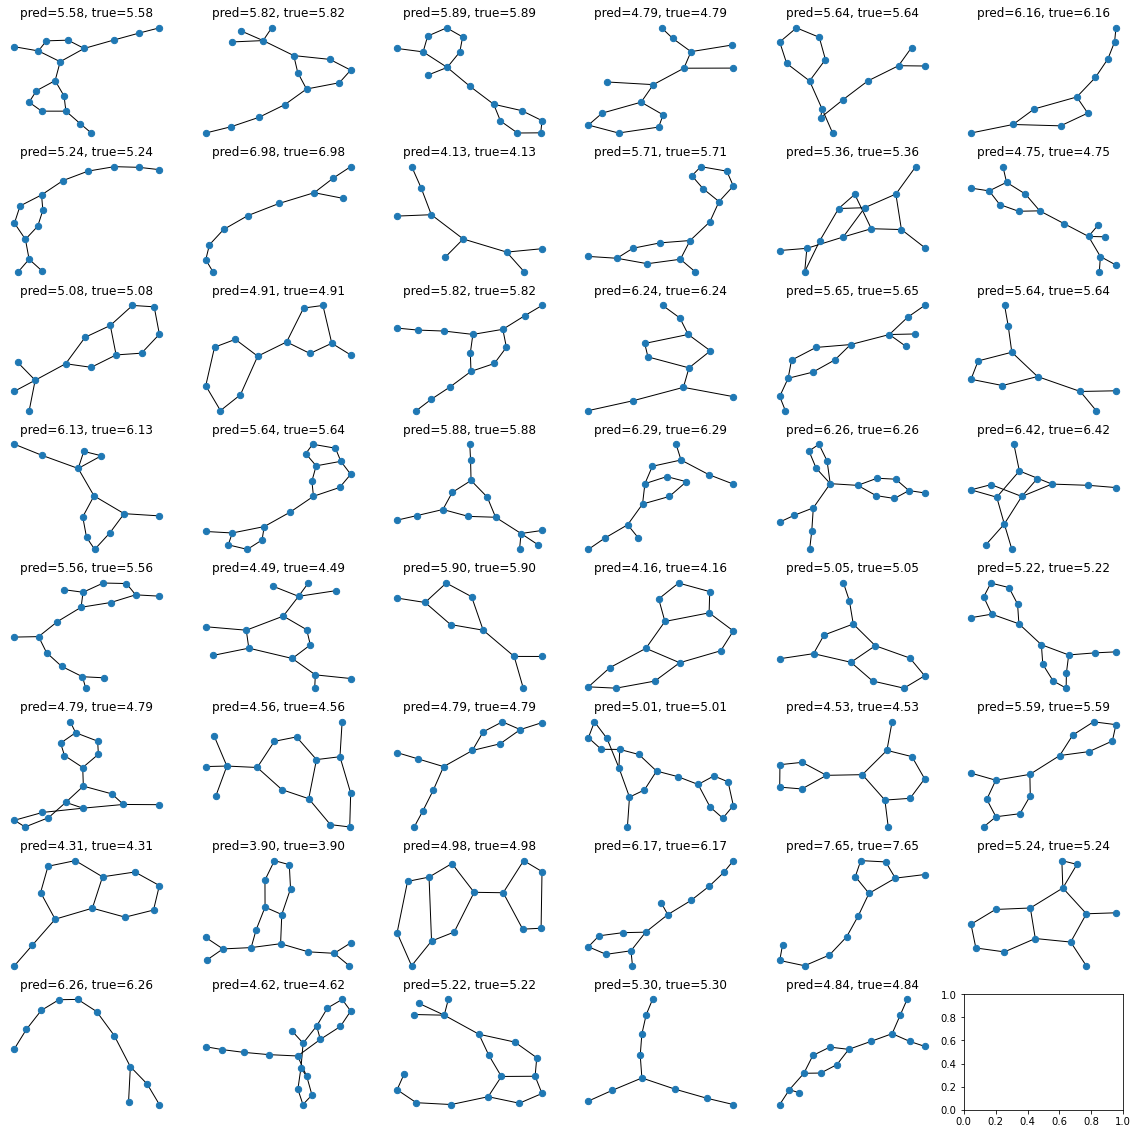

In [176]:
filtDF = validDF[validDF["absError"] < 0.00003 ].sort_values("absError")

plotGraph(filtDF, title="correctly predicted")

filtDF

In [178]:
data = filtDF.loc[380669].data
data.x, data.edge_attr

(tensor([[7, 0, 2, 5, 1, 0, 2, 0, 0],
         [5, 0, 4, 5, 2, 0, 2, 0, 0],
         [5, 0, 4, 5, 2, 0, 2, 0, 0],
         [5, 1, 4, 5, 1, 0, 2, 0, 1],
         [5, 0, 4, 5, 2, 0, 2, 0, 1],
         [7, 0, 2, 5, 0, 0, 1, 0, 1],
         [5, 0, 3, 5, 0, 0, 1, 0, 1],
         [7, 0, 1, 5, 0, 0, 1, 0, 0],
         [6, 0, 3, 5, 0, 0, 1, 0, 1],
         [5, 0, 3, 5, 0, 0, 1, 1, 1],
         [5, 0, 3, 5, 1, 0, 1, 1, 1],
         [5, 0, 3, 5, 1, 0, 1, 1, 1],
         [5, 0, 3, 5, 1, 0, 1, 1, 1],
         [5, 0, 3, 5, 0, 0, 1, 1, 1],
         [5, 0, 3, 5, 1, 0, 1, 1, 1],
         [7, 0, 2, 5, 0, 0, 1, 0, 0],
         [5, 0, 4, 5, 3, 0, 2, 0, 0]]),
 tensor([[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 1],
         [0, 0, 1],
         [1, 0, 1],
         [1, 0, 1],
         [0, 0, 1],
         [0, 0, 1],
         [0, 0, 1],
         [0,

positive error


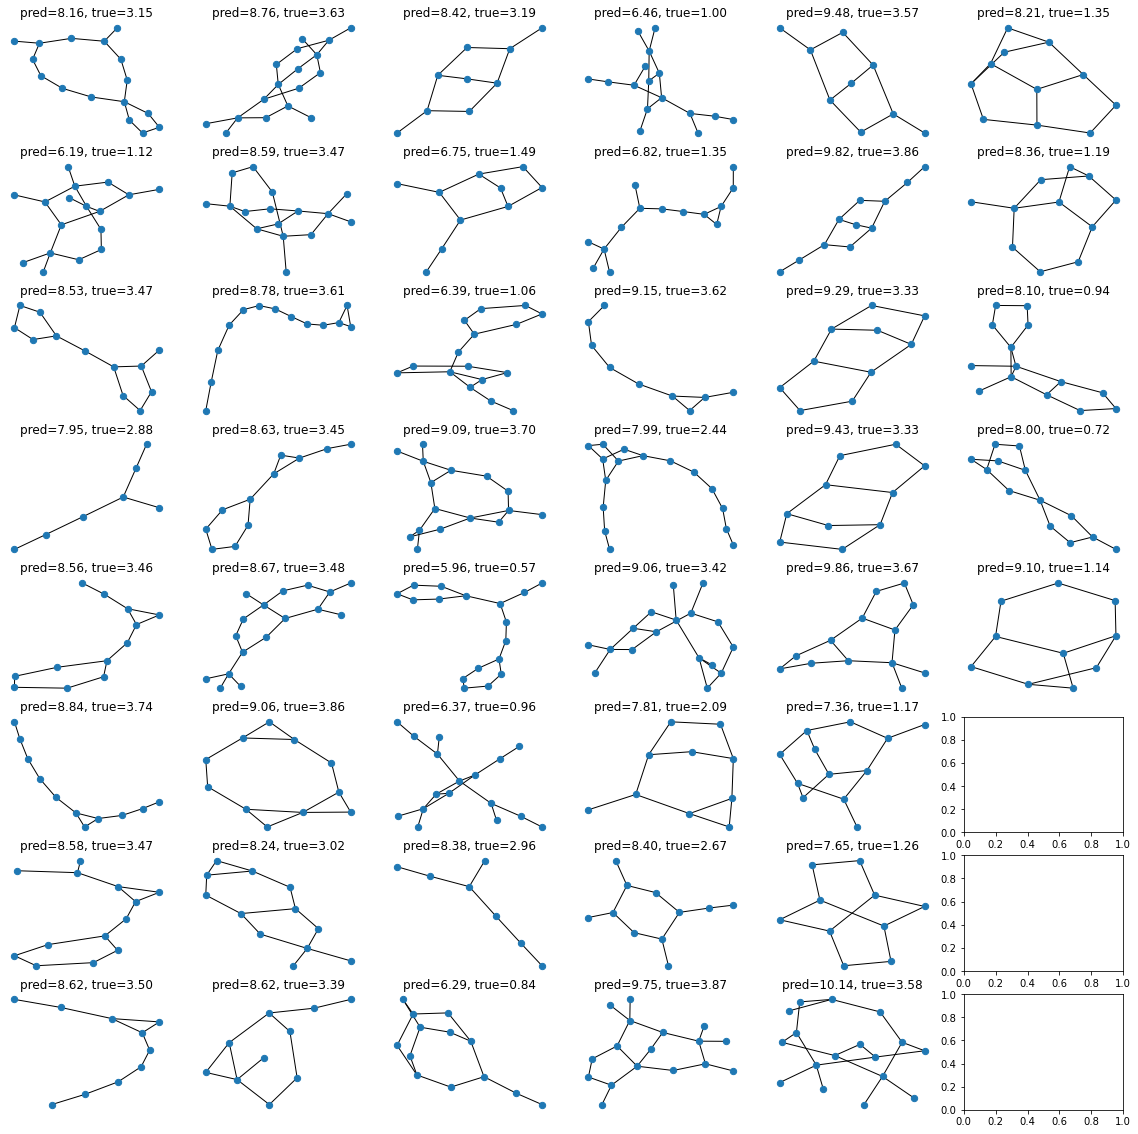

In [142]:
filtDF = validDF[validDF["error"] > 5].sort_values("absError")

plotGraph(filtDF, title="positive error")

# filtDF

positive error


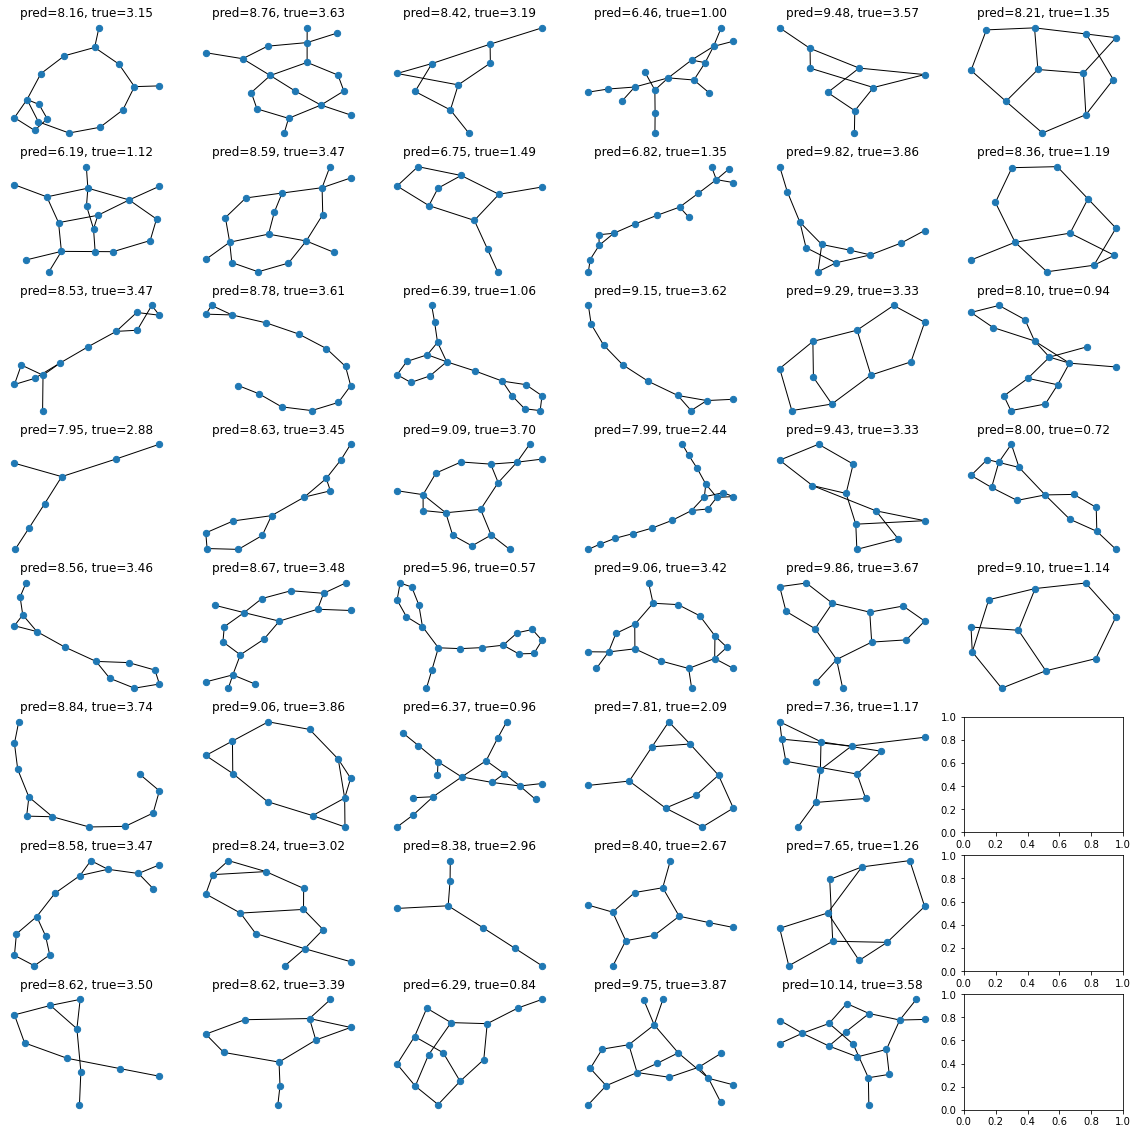

In [143]:
filtDF = validDF[validDF["error"] > 5].sort_values("absError")

plotGraph(filtDF, title="positive error")

# filtDF

negative error


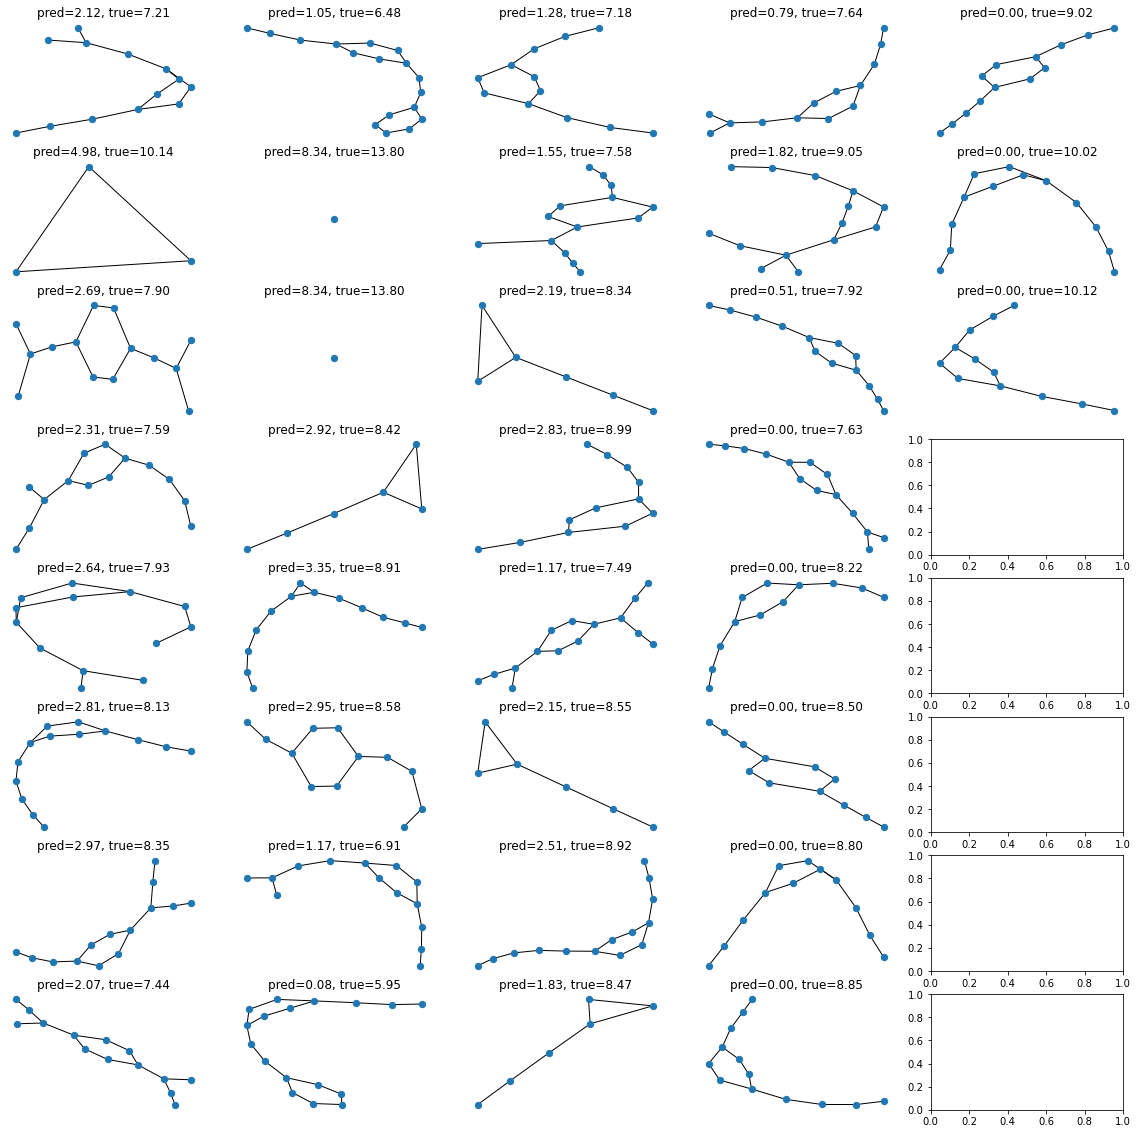

In [179]:
filtDF = validDF[validDF["error"] < -5].sort_values("absError")

plotGraph(filtDF, title="negative error")

# filtDF

In [183]:
data = filtDF.loc[0].data
data.x, data.edge_attr

(tensor([[5, 0, 4, 5, 3, 0, 2, 0, 0],
         [5, 0, 4, 5, 2, 0, 2, 0, 0],
         [5, 0, 4, 5, 2, 0, 2, 0, 0],
         [5, 0, 4, 5, 1, 0, 2, 0, 1],
         [5, 0, 4, 5, 2, 0, 2, 0, 1],
         [5, 0, 4, 5, 2, 0, 2, 0, 1],
         [5, 0, 4, 5, 1, 0, 2, 0, 1],
         [5, 0, 4, 5, 2, 0, 2, 0, 1],
         [5, 0, 4, 5, 2, 0, 2, 0, 1],
         [5, 0, 4, 5, 2, 0, 2, 0, 0],
         [5, 0, 4, 5, 2, 0, 2, 0, 0],
         [5, 0, 4, 5, 3, 0, 2, 0, 0]]),
 tensor([[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]))

In [168]:
filtDF.loc[44].data, filtDF.loc[45].data, filtDF.loc[42].data

(Data(edge_attr=[0, 3], edge_index=[2, 0], x=[1, 9], y=[1]),
 Data(edge_attr=[0, 3], edge_index=[2, 0], x=[1, 9], y=[1]),
 Data(edge_attr=[12, 3], edge_index=[2, 12], x=[6, 9], y=[1]))

positive error


,index,y_true,y_pred,data,error,absError
0,53895,10.122635,0.0,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",10.122635,10.122635
1,16288,10.021954,0.0,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",10.021954,10.021954
2,13967,9.020575,0.0,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",9.020575,9.020575
3,13965,8.851864,0.0,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",8.851864,8.851864
4,38862,8.802883,0.0,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",8.802883,8.802883
5,54780,8.503558,0.0,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",8.503558,8.503558
6,3430,8.220559,0.0,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",8.220559,8.220559
8,13966,7.627351,0.0,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",7.627351,7.627351
173,368727,4.236813,0.0,"[(edge_attr, [tensor([1, 0, 1]), tensor([1, 0,...",4.236813,4.236813
3483,13870,2.076229,0.0,"[(edge_attr, [tensor([0, 0, 1]), tensor([0, 0,...",2.076229,2.076229


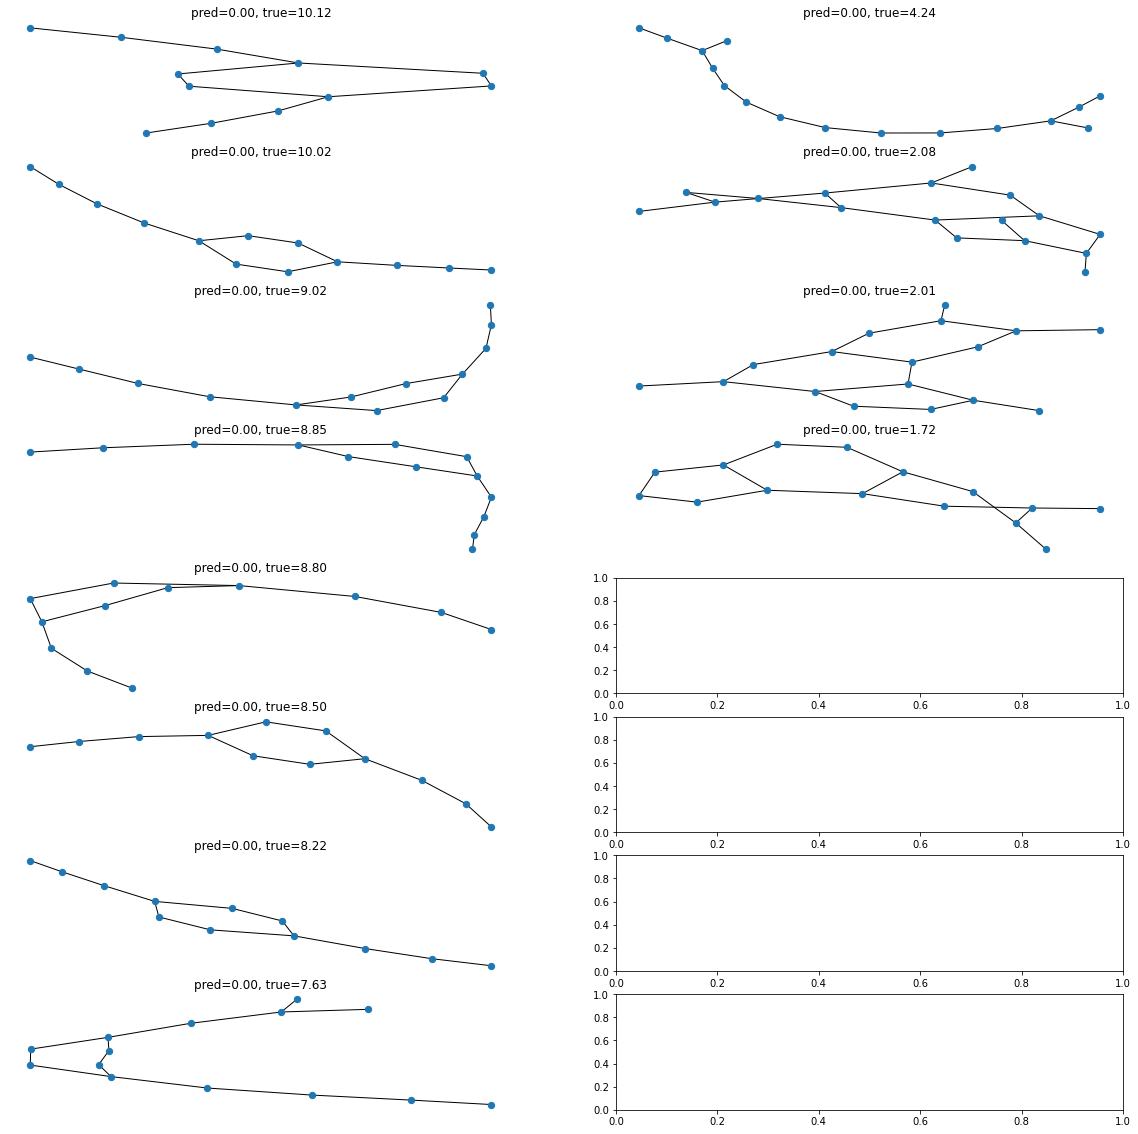

In [124]:
filtDF = validDF[validDF["y_pred"] == 0.0]

plotGraph(filtDF, title="positive error")

filtDF

## visualise graph embeddings

In [125]:
import seaborn as sns

In [126]:
"""
Get intermediate graph embeddings and visualise
"""

graphEmbeddings = None
y_true = []
for step, batch in enumerate(tqdm(valid_loader, desc="Iteration")):
    batch = batch.to(device)

    # get intermediate outputs
    h_node = model.gnn_node(batch)
    # GRAPH EMBEDDING
    h_graph = model.pool(h_node, batch.batch)
    output = model.graph_pred_linear(h_graph)

    # convert to numpy object
    h_graph_np = h_graph.detach().cpu().numpy()
    y_true.extend(batch.y.detach().cpu().numpy())

    if graphEmbeddings is None:
        graphEmbeddings = h_graph_np
    else:
        graphEmbeddings = np.concatenate((graphEmbeddings, h_graph_np))


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [05:28<00:00,  4.53it/s]


In [ ]:
from sklearn.decomposition import PCA

n_components = 4

pca = PCA(n_components=n_components)
pca.fit(graphEmbeddings)

pcaEmb = pca.transform(graphEmbeddings)

pcaEmbDF = pd.DataFrame(pcaEmb, columns=["dim{}".format(range(n_components))])
pcaEmbDF["y"] = y_true

plt.figure(figsize=(10, 10))
sns.scatterplot(data=pcaEmbDF, x="dim0", y="dim1", hue="y", palette="rocket")
plt.figure(figsize=(10, 10))
sns.scatterplot(data=pcaEmbDF, x="dim1", y="dim2", hue="y", palette="rocket")


graphEmbeddings.shape, pcaEmb.shape

## Integrated Gradient